## Chapter 13

**Exercise 13-1:**    In NSFG Cycles 6 and 7, the variable `cmdivorcx` contains the date of divorce for the respondent’s first marriage, if applicable, encoded in century-months.

Compute the duration of marriages that have ended in divorce, and the duration, so far, of marriages that are ongoing. Estimate the hazard and survival curve for the duration of marriage.

Use resampling to take into account sampling weights, and plot data from several resamples to visualize sampling error.

Consider dividing the respondents into groups by decade of birth, and possibly by age at first marriage.

In [83]:
def CleanData(resp): # This function provided by thinkstats2 cleans the data, finding and replacing nan values.
    """Cleans respondent data.

    resp: DataFrame
    """
    resp.cmdivorcx.replace([9998, 9999], np.nan, inplace=True)

    resp["notdivorced"] = resp.cmdivorcx.isnull().astype(int)
    resp["duration"] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
    resp["durationsofar"] = (resp.cmintvw - resp.cmmarrhx) / 12.0

    month0 = pd.to_datetime("1899-12-15")
    dates = [month0 + pd.DateOffset(months=cm) for cm in resp.cmbirth]
    resp["decade"] = (pd.DatetimeIndex(dates).year - 1900) // 10

In [116]:
CleanData(resp6) # Uses the CleanData function to clean the resp6 and resp7 data frame
married6 = resp6[resp6.evrmarry == 1] # Creates a new data frame from the existing data frame but only selects the 
# respondents that have been married.

CleanData(resp7)
married7 = resp7[resp7.evrmarry == 1]

In [149]:
print(type(married6)) # Exploring the type created
married6.head() # viewing the data frame

<class 'pandas.core.frame.DataFrame'>


,caseid,cmbirth,evrmarry,cmmarrhx,cmdivorcx,parity,finalwgt,cmintvw,agemarry,age,year,decade,fives,notdivorced,duration,durationsofar
1,5012,718,True,974.0,1077.0,1,4744.191350,1233,21.333333,42.916667,59,5,11,0,8.583333,21.583333
2,11586,708,True,910.0,938.0,1,4744.191350,1234,16.833333,43.833333,58,5,11,0,2.333333,27.000000
5,845,727,True,937.0,NaN,6,4705.681352,1234,17.500000,42.250000,60,6,12,1,NaN,24.750000
8,8656,780,True,1003.0,NaN,3,6520.021223,1237,18.583333,38.083333,64,6,12,1,NaN,19.500000
10,5917,714,True,953.0,NaN,2,3488.586646,1233,19.916667,43.250000,59,5,11,1,NaN,23.333333


In [118]:
# Defining the function ResampleDivorceCurve()

def ResampleDivorceCurve(resp):
    """Plots divorce curves based on resampled data.

    resps: list of respondent DataFrames
    """
    for _ in range(11):
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        PlotDivorceCurveByDecade(sample, color="#225EA8", alpha=0.1)

    thinkplot.Show(xlabel="years", axis=[0, 28, 0, 1])

In [88]:
# Defining a function to resample specified data

def ResampleDivorceCurveByDecade(resps):
    """Plots divorce curves for each birth cohort.

    resps: list of respondent DataFrames
    """
    for i in range(41):
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby("decade")
        if i == 0:
            survival.AddLabelsByDecade(groups, alpha=0.7)

        EstimateSurvivalByDecade(groups, alpha=0.1)

    thinkplot.Config(xlabel="Years", ylabel="Fraction undivorced", axis=[0, 28, 0, 1])

In [89]:
# Defining the function EstimateSurvivalbyDecade()

def EstimateSurvivalByDecade(groups, **options):
    """Groups respondents by decade and plots survival curves.

    groups: GroupBy object
    """
    thinkplot.PrePlot(len(groups))
    for name, group in groups:
        _, sf = EstimateSurvival(group)
        thinkplot.Plot(sf, **options)

In [137]:
# Defining the function EstimateSurvival() that returns the hazard function and survival function values

def EstimateSurvival(resp):
    """Estimates the survival curve.

    resp: DataFrame of respondents

    returns: pair of HazardFunction, SurvivalFunction
    """
    complete = resp[resp.notdivorced == 0].duration.dropna()
    ongoing = resp[resp.notdivorced == 1].durationsofar.dropna()

    hf = survival.EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

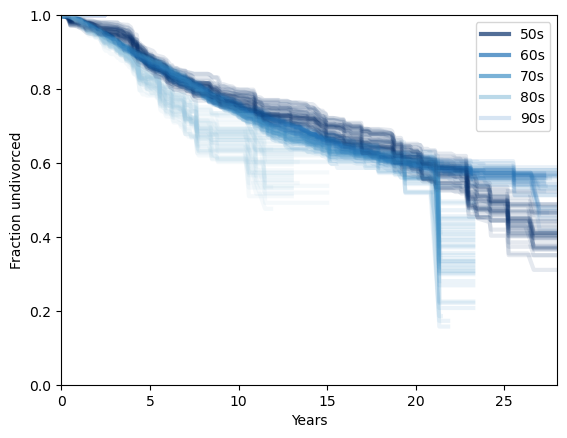

In [91]:
# A plot of the variables married6 and maried7 by decade. 

ResampleDivorceCurveByDecade([married6, married7])

This assignment has been one of the more challenging to understand and follow. It appears the functions build on each other until ultimately providing the data for the plot. 